## TF-IDF

\begin{equation}
w_{i,j} = \text{tf}_{i,j} \log\left(\frac{N}{\text{df}_i}\right)
\end{equation}

$i$ palabra o n-grama <br>
$j$ documento <br>
$\text{tf}_{i,j}$ cantidad de ocurrencias de $i$ en $j$ <br>
$\text{df}_i$ cantidad de documentos con contienen $i$ <br>
$N$ cantidad total de documentos


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/document_type_data.csv',
                 converters={'text': literal_eval})

corpus = df['text'].to_list()

corpus_text = []
for doc in corpus:
    text = ''
    for word in doc:
        text += ' ' + word
    corpus_text.append(text)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(corpus_text).toarray()
labels = df.label.astype('category').cat.codes.values

In [9]:
features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13350475, 0.        , 0.20275662, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08669342, 0.        ,
        0.09033558],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [5]:
print(corpus_text[0])

 Chaikin,  Karen  n  O'  o  From:  Sent:  To:  Subject:  Chaikin,  Karen  Monday,  July  16,  2001  7:24  PM  'plomba'dogtnadcomcom'  RE:  RFP  and  Op  Plan  KC  Youth  Smoking  Prevention  hJ  Q  oe  Vi  Phil,  Thanks  for  all  of  these.  Note  that  I  cannot  open  the  marked  version  of  the  Op  Plan.  Can  you  please  re-convert  to  a  pdf  and  resend?  Thanks! 


### Observar los unigramas y bigramas más frecuentes

In [6]:
N = 2
for label, label_id in zip(df.label.unique().tolist(), [0, 1, 2, 3]):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'email':
  . Most correlated unigrams:
. subject
. sent
  . Most correlated bigrams:
. sent subject
. original message
# 'invoice':
  . Most correlated unigrams:
. 00
. invoice
  . Most correlated bigrams:
. york ny
. 30 days
# 'letter':
  . Most correlated unigrams:
. sincerely
. dear
  . Most correlated bigrams:
. philip morris
. tobacco institute
# 'resumee':
  . Most correlated unigrams:
. biology
. university
  . Most correlated bigrams:
. assistant professor
. university california


In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

print(cv_df.groupby('model_name').accuracy.mean())

model_name
LinearSVC                 0.98
LogisticRegression        0.96
MultinomialNB             0.96
RandomForestClassifier    0.97
Name: accuracy, dtype: float64


### Elijo el modelo con mejor performance

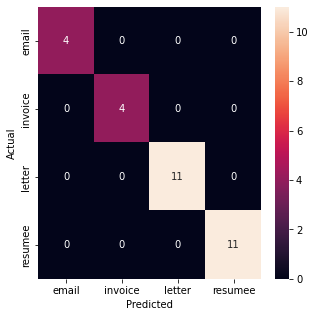

In [12]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, df.index, test_size=0.3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df.label.unique().tolist(), 
            yticklabels=df.label.unique().tolist())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()